一个技术人员，在遇到人生中的第一个技术瓶颈的时候，打破这个瓶颈一般有两种方式：1. 开源项目 2. 阅读源码。就我而言, 目前阶段去做个人开源项目，一是没有足够的灵感积累，而是目前的技术还不达标。所以，阅读源码成了我提升的选择。对于三种框架Django、flask和tornado, 本人选择flask和tornado两个框架用来练手, 因为之前看过一点flask的框架, 再加上现在工作过程中使用到了异步, 所以这里就先选择阅读tornado的源码.

阅读tornado源码期待达成的目标：
1. 掌握tornado的整体流程
2. 掌握tornado的异步实现原理
3. 吸收tornado的编码细节, 从类的定义、函数的定义等多个角度去吸收

大体有以下几个方面细节可以入手：
1. cookie和session
2. xsrf攻击
3. 日志
4. 数据库操作
5. 应答response的压缩或其他处理
6. 中间件
7. 重定向, 多级路由
8. 数据的流式取和流式返回
9. 配置文件采用的格式以及解析方式
10. 信号
11. websocket
12. wsgi, asgi
13. 部署

在阅读一个框架的源码的时候，尤其是想要弄明白里面的细节问题，就应该对框架的使用有一定程度的了解，仅仅是学习一个小型框架的基本使用花不了多长时间，这个时间也是值得投入的。





In [16]:
import tornado.web
import tornado.ioloop


class MainHandler(tornado.web.RequestHandler):
    def get(self):
        print(self.request.headers)

        print(self.application.settings)
        self.write({"name": "jack"})


class IndexHandler(tornado.web.RequestHandler):
    def get(self, num, nid):
        self.write(str(num + nid))

settings = {
    'debug': True,
    'gzip': True,
    'autoescape': None,
    'xsrf_cookies': False,
    'cookie_secret': 'xxxx'
}

application = tornado.web.Application([
    (r"/", MainHandler),
    (r"/index/(?P<num>\d+)/(?P<nid>\d+)", IndexHandler)
], **settings)

if __name__ == '__main__':
    application.listen(8888)
    tornado.ioloop.IOLoop.instance().start()


看了上面最简单的使用案例来说，我们可能有如下疑问：

1. tornado.web.RequestHandler 是个什么鬼，凭什么我们写一个类继承自它里面写一些get, post方法就行了
2. 为什么在我们写的MainHandler里面可以获取请求self.request, 还可以获取self.application, tornado.web.RequestHandler到底帮我们做了些啥
3. tornado.web.Application类传了两个参数进去, 第一个参数是列表套元组的形式，第二个参数是配置字典, 然后就能路由匹配到我们写的MainHandler啦？
4. application.listen: 啥? application去listen, 我们的socket的创建和监听在哪里做的
5. tornado.ioloop.IOLoop.instance().start(): 开启ioloop, ioloop 又是怎么个玩意, 开启它干嘛使呢？我们之间创建socket并等待连接不就行了吗，引入这么个看似复杂的玩意干嘛呢？
6. self.write({"name": "jack"}), 这里既然可以返回字符串、字典，那么能不能返回列表呢？我们在这里write的数据, 框架究竟帮我们做了哪些事？

以上问题是一个人第一眼看到这段代码可能会提出的几个问题, 从这些问题中我们可以总结出日后我们自己开源框架应该怎么去做：尽可能地简化用户的操作, 将细节进行封装, 另外io多路复用是实现并发的一项技术, 这一点在打着高并发的tornado框架中得到了很好的体现.另外, 马上就要开启tornado的源码之旅, 在第一遍看源码的过程中不要陷进去, 头脑一定要保持清醒: 我们这一次看源码是为了解决什么样的疑惑, 没必要在很多细节的问题上究竟。等我们理清了这些疑惑之后, 看第二遍第三遍的时候再去逐步深入各种细节问题。



在正式看源码之前，关上电脑，如果让我们去实现这么一段代码功能，那我们应该怎么去做？但凡是有一点编程基础的，可能会有如下想法：作为服务端，创建一个用于处理连接的socket, 然后把这个socket交给linux操作系统的epoll去帮我们监听,一下子有10个用户过来连接了(三次握手建立连接，此时还没有发送请求数据), accept一次就会生成一个相应的conn, 这时把这个coon也交给epoll去帮我们监听，然后接着accept 9次, "生产"9个conn交给epoll去帮我们监听。这10个连接其中如果有3个连接发送了请求数据到服务端，那么假设服务端采用单进程单线程模型，这3个请求来了，服务端使用循环拿到请求数据并一个个去做相应的处理。那么这里问题来了，如果在处理一个请求的过程中发生阻塞(比如第一个请求的处理函数中对数据库做查询操作且查询很慢或者在处理函数中往别地发了一个网络请求), 势必会影响到另外的2个请求的处理。这时候就需要我们在处理函数中编写这类阻塞代码使用正确的姿势了, tornado 1.2版本中使用的是回调(其他版本暂时没研究过), 可以说在tornado早期版本中回调随处可见。

处理单个请求的过程应该是什么样的呢?拿到http请求报文, 并根据http协议进行解析封装成一个[HTTPRequest](#HTTPRequest)对象, 然后我们根据请求去匹配路由，找到对应的handler, 根据请求的method去调用handler不同的方法做数据相应处理, 并通过conn发送数据。有了epoll之后我们可以把数据的发送和conn进行绑定，等conn可以发送的时候再去发送数据。我们发现，有了epoll之后我们就可以把socket对象和要进行的处理回调全部一股脑交给epoll去监听，然后我们在一个事件循环中去获取就绪的描述符和相应的回调函数。

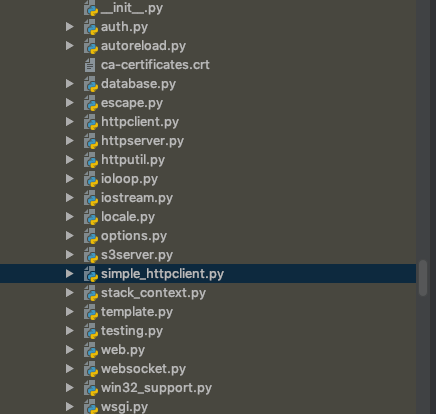

# web_server 

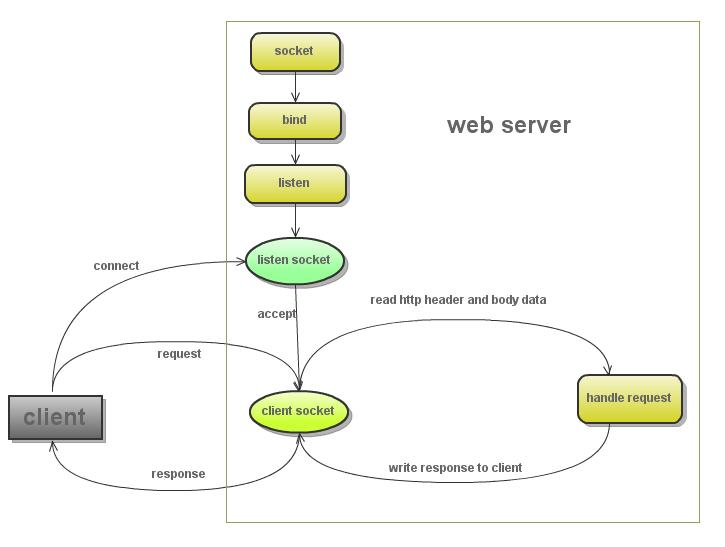
1. 服务器端bind到一个端口，然后开始listen。
2. 客户端connect上来以后，将请求发送给服务端。
3. 服务端处理完成后返回给客户端。

这样，一个请求就处理结束了。不过，当需要处理成千上万的连接的时候，我们就会在这个基础上考虑更多的情况，这也就是大家熟悉的The C10K problem。Tornado采用的解决办法是：多进程 + 非阻塞 + epoll模型。

<font color="red">这里留一个问题：为什么io多路复用常常和非阻塞io联系在一起？事件循环有内容的时候，此时socket是可以读写的，那么socket设置成非阻塞的意义何在呢？</font>

在网上看到一张图，感觉画的不错，等tornado源码看完之后再回过头看这个图就很简单了





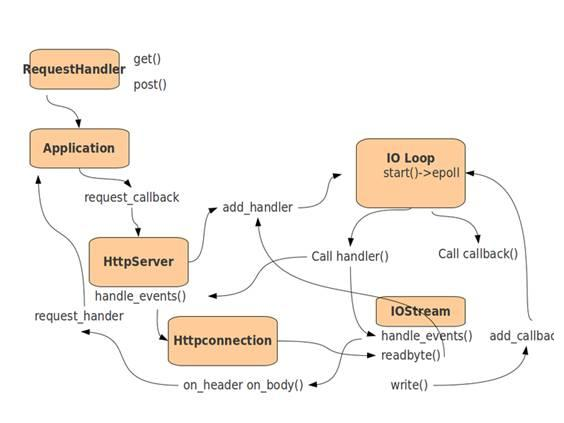

# tornado的class

* [HTTPServer](#section_id2):处理套接字的 listen/bind/accept。
* [IOStream](#section_id4): 处理套接字的 read/write。
* [HTTPConnection](#section_id3): 处理与 HTTP client 建立的连接，解析 HTTP Request 的 header 和 body, 调用用户自定义的处理方法，以及把响应数据写给客户端socket。
* [HTTPRequest](#HTTPRequest): http 请求对象, 包含了请求头、请求体等数据
* [IOLoop](#IOLoop): I/O loop，循环取出可用的 fd，并调用对应的事件处理函数。
* [RequestHandler](#RequestHandler): 处理请求，支持 GET/POST 等操作。


# 大体流程

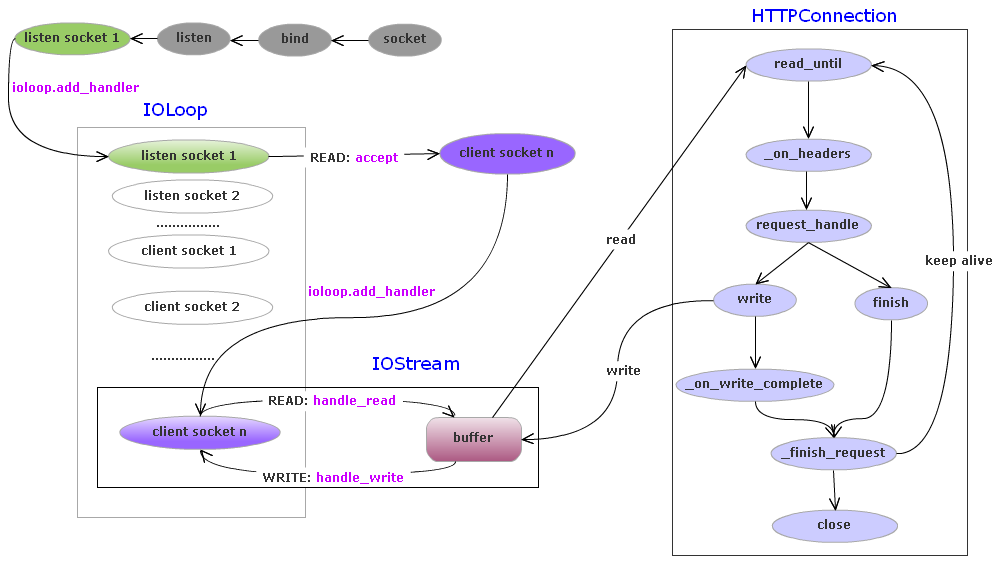

现在看这图可能不能完全get到里面所有的点, but没关系, 随着源码看的越来越多, 也就可以理解上面的图了。

# tornado.web.Application

从上面的例子可以看到application封装了路由和自定义handler对应关系，还放了settings, 然后调用了一下applicatio.listen(8888).
先不看源码，我们来猜一猜就这样2步：初始化和listen(8888)分别应该干了些什么事?
初始化: 绑定了url和handler的对应关系.
listen: 创建了一个socket, 监听端口, 并把这个socket交给epoll去监听。

<font color="red">这里提出一个问题：对于"/index/(?P<num>\d+)/(?P<nid>\d+)", 是怎样对应到get(self, num, nid)中的num和nid参数的？</font>

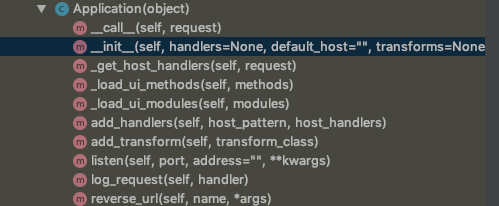

Application对外方法：
* [add_handlers](#aah)(self, host_pattern, host_handlers)
* [add_transform](#add_transform)(self, transform_class)
* [listen](#al)(self, port, address="", **kwargs)
* [log_request](#alr)(self, handler)
* [reverse_url](#aru)(self, name, *args)

内部方法：
* `__init__(self, handlers=None, default_host="", transforms=None, wsgi=False, **settings)`
* `__call__(self, request)`

## 构造方法

看一个方法，关注输入输出。输入：有2个参数值得注意，列表的handlers和字典的settings. 构造方法没有输出，那就关注在构造方法里给application对象绑定了什么属性：一般在构造方法会把这个对象所有应该有的属性都设置上，哪怕初始化时的时候属性是空，在后续的方法也会把这个属性的值给填充上。我们需要关注的是application绑定的属性有：transforms(用户传值以用户传的为准，这里用户传的必须是一个列表，用户没传根据settings去设置，默认会添加一个ChunkedTransferEncoding), settings, handlers. 对于这几个属性的数据结构是什么，里面放置的是什么我们也应该有所认识。其中<font color="red">transforms是list,里面存放ChunkedTransferEncoding、GZipContentEncoding等类</font>，handlers是list，里面存放什么需要看self.add_handlers方法，当然我们传给构造方法的handlers里列表套元组的形式。

In [1]:
def __init__(self, handlers=None, default_host="", transforms=None,
             wsgi=False, **settings):
    if transforms is None:
        self.transforms = []
        if settings.get("gzip"):
            self.transforms.append(GZipContentEncoding)
        self.transforms.append(ChunkedTransferEncoding)
    else:
        self.transforms = transforms
    self.handlers = []
    self.named_handlers = {}
    ...
    self.settings = settings
    ...
    self._wsgi = wsgi
    ...
    if self.settings.get("static_path"):
        path = self.settings["static_path"]
        handlers = list(handlers or [])
        static_url_prefix = settings.get("static_url_prefix",
                                         "/static/")
        handlers = [
            (re.escape(static_url_prefix) + r"(.*)", StaticFileHandler,
             dict(path=path)),
            (r"/(favicon\.ico)", StaticFileHandler, dict(path=path)),
            (r"/(robots\.txt)", StaticFileHandler, dict(path=path)),
        ] + handlers
    if handlers: self.add_handlers(".*$", handlers)

    # Automatically reload modified modules
    ...

## <a id="aah">add_handlers</a>

add_handlers接收2个参数, 一个是字符串的host_pattern, 另一个是列表套元组的host_handlers。含义是主机名：主机一系列url 对应关系。
参数host_handlers是一个list，list里每个object是一个URLSpec的对象或tuple。tuple可以是二到四个element，分别是URI的正则、handler类、用于初始化URLSpec的kwargs、handler的name。从下面代码可以看出最终<font color="red">self.handlers的数据结构是`[("host1", [URLSpec(), URLSpec()]),("host2", [URLSpec(), URLSpec()])]`.</font> 

这里有一个问题需要思考, 为啥要把pattern, handler, kwargs组成一个URLSpec对象呢？从我的角度去理解的话，把这3个玩意封装成一个对象，对象除了包含这3个属性之外，还会有一些针对这3个属性的一些方法。所以在以后我们可能需要用到这个对象里的一些方法，那么这个对象有哪些方法呢？
[URLSpec](#section_id).



In [2]:
def add_handlers(self, host_pattern, host_handlers):
        # add_handlers 做的事更像是二级路由，先匹配主机名，然后在去匹配路由规则
        if not host_pattern.endswith("$"):
            host_pattern += "$"
        handlers = []
        # 对主机名先做一层路由映射，例如：http://www.wupeiqi.com 和 http://safe.wupeiqi.com
        # 即：safe对应一组url映射，www对应一组url映射，那么当请求到来时，先根据它做第一层匹配，之后再继续进入内部匹配。

        # 对于第一层url映射来说，由于.*会匹配所有的url，所将 .* 的永远放在handlers列表的最后，不然 .* 就会截和了
        # add_handlers 可能会被调用多次，所以才有如下判断, 并且第一个条件的and是我们可以吸收的一个写代码的思路
        if self.handlers and self.handlers[-1][0].pattern == '.*$':
            self.handlers.insert(-1, (re.compile(host_pattern), handlers))
        else:
            self.handlers.append((re.compile(host_pattern), handlers))
        # host_handlers 是用户传的list套tuple的数据
        for spec in host_handlers:
            if isinstance(spec, type(())):
                assert len(spec) in (2, 3)
                pattern = spec[0]
                handler = spec[1]
                # kwargs = spec[2] if len(spec) == 3 else {}, 保证可以传kwargs参数
                if len(spec) == 3:
                    kwargs = spec[2]
                else:
                    kwargs = {}
                # 这里把pattern, 自定义的handler, 需要给handler的参数kwargs封装成一个对象
                spec = URLSpec(pattern, handler, kwargs)
            handlers.append(spec)

            if spec.name:
                if spec.name in self.named_handlers:
                    logging.warning(
                        "Multiple handlers named %s; replacing previous value",
                        spec.name)
                self.named_handlers[spec.name] = spec

## <a id="al">listen</a>

application的listen其实没必要存在，就是一个简单的包装，这种包装很容易让不看源码的人产生疑惑。listen所做的是就是创建一个[HTTPServer](#section_id2)，将application绑定上去。[HTTPServer](#section_id2)

In [ ]:
def listen(self, port, address="", **kwargs):
    # import is here rather than top level because HTTPServer
    # is not importable on appengine
    from tornado.httpserver import HTTPServer
    server = HTTPServer(self, **kwargs)
    server.listen(port, address)

## `__call__`

[HTTPConnection](#section_id3)解析完header和body之后调用`self.request_callback(self._request)` 执行Application的`__call__方法`。首先，我们还是可以猜测一下这个方法里应该完成什么样的事：因为参数是request, 所以可以拿到request.path, 然后进行匹配，选择对应的Handler类并实例化，再根据request.method去调用Handler对应的方法。和Handler的结合点的两行代码：`handler = spec.handler_class(self, request, **spec.kwargs)`以及`handler._execute(transforms, *args, **kwargs)`.
<font color="red">新知识点：groupdict和groups</font>

In [11]:
def __call__(self, request):
    """Called by HTTPServer to execute the request."""
    transforms = [t(request) for t in self.transforms]
    handler = None
    # args和kwargs就是我们路由捕捉的参数, 也就是我们常常在我们自定义Handler的get方法里看到的get(self, *args, **kwargs).
    args = []
    kwargs = {}
    handlers = self._get_host_handlers(request)
    if not handlers:
        handler = RedirectHandler(
            self, request, url="http://" + self.default_host + "/")
    else:
        # [URLSpec(), URLSpec()]
        for spec in handlers:
            match = spec.regex.match(request.path)
            if match:
                # url反编译
                def unquote(s):
                    if s is None: return s
                    return urllib.unquote(s)
                # 实例化handler
                handler = spec.handler_class(self, request, **spec.kwargs)
                kwargs = dict((k, unquote(v))
                              for (k, v) in match.groupdict().iteritems())
                if kwargs:
                    args = []
                else:
                    args = [unquote(s) for s in match.groups()]
                # 从前到后匹配，匹配上就不往后匹配了
                break
        # 没有一个匹配上，使用ErrorHandler去处理
        if not handler:
            handler = ErrorHandler(self, request, status_code=404)
    ...
    handler._execute(transforms, *args, **kwargs)
    return handler

In [ ]:
In [1]: import re

In [2]: spec = re.compile(r"/index/(?P<name>\w+)")

In [3]: match = spec.match("/index/jack")

In [4]: match.group()
Out[4]: '/index/jack'

In [5]: match.groups()
Out[5]: ('jack',)

In [6]: match.groupdict()
Out[6]: {'name': 'jack'}

## `_get_host_handlers`

根据host得到该host的handlers列表。

In [ ]:
def _get_host_handlers(self, request):
    host = request.host.lower().split(':')[0]
    for pattern, handlers in self.handlers:
        if pattern.match(host):
            return handlers
    ...
    return None

# <a id="section_id">URLSpec</a>

URLSpec这个类比较简单, 就是一个简单的工具类. 对于其构造方法，我们关注的是单个参数，字符串的pattern，类名handler_class以及字典kwargs。

In [ ]:
class URLSpec(object):
    def __init__(self, pattern, handler_class, kwargs={}, name=None):
        if not pattern.endswith('$'):
            pattern += '$'
        # 把正则直接编译好，后续直接调用
        self.regex = re.compile(pattern)
        self.handler_class = handler_class
        self.kwargs = kwargs
        
        self.name = name
        
        self._path, self._group_count = self._find_groups()

    def _find_groups(self):
        """Returns a tuple (reverse string, group count) for a url.

        For example: Given the url pattern /([0-9]{4})/([a-z-]+)/, this method
        would return ('/%s/%s/', 2).
        """
        # 大致看了下_find_groups的输出，那段for fragment in pattern.split('(')有点垃圾，re.sub(r"\(.+?\)", "%s", pattern)就能完成相同功能
        # 所以下面的代码没必要看了，唯一需要关注的是这个方法的输出('/%s/%s/', 2)，以及/([0-9]{4})/([a-z-]+)/ 这样被编译后的regex的两个属性：pattern和groups
        pattern = self.regex.pattern
        if pattern.startswith('^'):
            pattern = pattern[1:]
        if pattern.endswith('$'):
            pattern = pattern[:-1]

        if self.regex.groups != pattern.count('('):
            # The pattern is too complicated for our simplistic matching,
            # so we can't support reversing it.
            return (None, None)

        pieces = []
        for fragment in pattern.split('('):
            if ')' in fragment:
                paren_loc = fragment.index(')')
                if paren_loc >= 0:
                    pieces.append('%s' + fragment[paren_loc + 1:])
            else:
                pieces.append(fragment)

        return (''.join(pieces), self.regex.groups)

    def reverse(self, *args):
        # reverse 方法就是就是一个简单的字符串格式化"%s%s"%("name", "age"), 封装成一个方法也是为了做一些简单地校验
        assert self._path is not None, \
            "Cannot reverse url regex " + self.regex.pattern
        assert len(args) == self._group_count, "required number of arguments "\
            "not found"
        if not len(args):
            return self._path
        return self._path % tuple([str(a) for a in args])

# <a id="section_id2">HTTPServer</a>

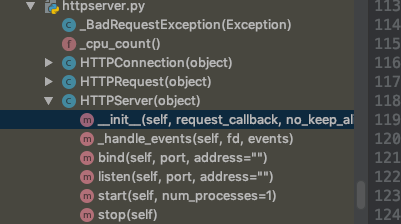

HTTPServer类的外部方法：
* [bind](#hb)(self, port, address="")
* [listen](#hl)(self, port, address="")
* [start](#lstart)(self, num_processes=1)
* [stop](#lstop)(self): 

HTTPServer类的内部方法：
* `__init__(self, request_callback, no_keep_alive=False, io_loop=None, xheaders=False, ssl_options=None)`
* [`_handle_events`](#hhe)(self, fd, events)

还是和之前一样，不看源码的情况下我们来猜测一些这个类。HTTPServer?处理http请求的服务器?既然是服务器, 那么肯定涉及到socket.所以这个类肯定有创建socket并监听socket等操作。另外, 它是http类型的服务器, 那么这个服务器有对http协议做解析吗？再结合io多路复用, 进一步猜测创建的这个socket绑定read事件，当有客户端来连接时，那么就accept得到一个conn, 然后我们就能拿着这个conn去服务客户端了。框架比我们自己写的那种简单的httpserver复制的地方就是在对于conn的处理上，框架用了一系列类做了很多的事情。
                 

# 构造方法

我们发现在构造方法里，有如下4个属性值得关注：request_callback(application对象)、no_keep_alive、io_loop、_started。
在httpserver中封装了application对象, io_loop和socket. ioloop和socket是必不可少的, 因为要做io多路复用嘛，至于_started可以看做是一个辅助参数了。
<font color="red">这里有一个问题。长连接是怎么做到的</font>

In [ ]:
def __init__(self, request_callback, no_keep_alive=False, io_loop=None,
             xheaders=False, ssl_options=None):
    self.request_callback = request_callback
    # 默认是保持长连接
    self.no_keep_alive = no_keep_alive
    self.io_loop = io_loop
    ...
    self._socket = None
    self._started = False

## <a id="hb">bind</a>

bind：创建socket, 绑定ip和端口，listen。bind函数其实说白了就是socket server初始的三步战略。

In [1]:
def bind(self, port, address=""):
    
    assert not self._socket
    ...
    self._socket.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
    self._socket.setblocking(0)
    self._socket.bind((address, port))
    self._socket.listen(128)

## <a id="lstart">start</a>

在[IOLoop](#IOLoop)中去开启服务器，说白了就是让epoll去帮我们看着socket. 接收的参数num_processes表示创建的进程数，num_processes<0会内部纠正为服务器的cpu个数。torndao中的多进程体现在这：因为多进程的是写时复制，所以这里开了多个进程，在每个进程中用不同的[IOLoop](#IOLoop)对象去监视同一个socket描述符。这里给socket绑定监听事件，<font color="red">绑定的函数是_handle_events, 这个函数很重要，可以看做是一切的起始地.</font>

In [2]:
def start(self, num_processes=1):
    """Starts this server in the IOLoop.
    """
    # 保证start方法只能被调用一次
    assert not self._started
    self._started = True
    if num_processes is None or num_processes <= 0:
        num_processes = _cpu_count()
    if num_processes > 1 and ioloop.IOLoop.initialized():
        logging.error("Cannot run in multiple processes: IOLoop instance "
                      "has already been initialized. You cannot call "
                      "IOLoop.instance() before calling start()")
        num_processes = 1
    if num_processes > 1:
        logging.info("Pre-forking %d server processes", num_processes)
        for i in range(num_processes):
            # 子进程
            if os.fork() == 0:
                import random
                from binascii import hexlify
                try:
                    # If available, use the same method as
                    # random.py
                    seed = long(hexlify(os.urandom(16)), 16)
                except NotImplementedError:
                    # Include the pid to avoid initializing two
                    # processes to the same value
                    seed(int(time.time() * 1000) ^ os.getpid())
                random.seed(seed)
                self.io_loop = ioloop.IOLoop.instance()
                self.io_loop.add_handler(
                    self._socket.fileno(), self._handle_events,
                    ioloop.IOLoop.READ)
                # 这里必须return, 否则会死循环的
                return
        os.waitpid(-1, 0)
    else:
        if not self.io_loop:
            self.io_loop = ioloop.IOLoop.instance()
        self.io_loop.add_handler(self._socket.fileno(),
                                 self._handle_events,
                                 ioloop.IOLoop.READ)

## <a id="hl">listen</a>

listen就是提供给外部调用者的一个方法，外部调用者直接调用这个方法，它不需要知道创建socket和给[IOLoop](#IOLoop)去监听的细节。

In [3]:
def listen(self, port, address=""):
    """Binds to the given port and starts the server in a single process.

    This method is a shortcut for:

        server.bind(port, address)
        server.start(1)

    """
    self.bind(port, address)
    self.start(1)

## <a id="lstop">stop</a>

移除[IOLoop](#IOLoop)中监听的描述符，关闭socket对象

In [4]:
def stop(self):
    self.io_loop.remove_handler(self._socket.fileno())
    self._socket.close()

## <a id="hhe">`_handle_events `</a>

在`_handle_events`里面对socket进行accept操作，并创建了一个[IOStream](#section_id4)对象，以及一个用来处理连接的[HTTPConnection](#section_id3)对象。`_handle_events`是一个死循环，因为一次可能有多个客户端过来连接，此时就可以accept多次。当accept报错时，循环退出。可以看到，我们每次accept得到一个connection, 最终的处理方式就是仅仅实例化一个[HTTPConnection](#section_id3)对象，实例化这个对象也就算了，竟然没有调用这个对象的任何方法就能把一个客户端连接给处理了，这和一般的惯性思维不太一样啊。那么是不是在[HTTPConnection](#section_id3)的构造方法里就直接调用了某些方法呢？感觉也不是，如果[HTTPConnection](#section_id3)是顺序去处理连接的内容的话，一旦某个连接出现了阻塞，那么势必会影响下一轮的accept循环，这样tornado就不是之前吹嘘的高性能框架了。那到底是怎么做的呢？

In [6]:
def _handle_events(self, fd, events):
    while True:
        try:
            connection, address = self._socket.accept()
        except socket.error, e:
            # 多进程情况下，当socket可read时，多个进程的ioloop都能感知到，如果第一个进程进行了accept，那么别的进程就会走到下面的错误直接return
            if e.args[0] in (errno.EWOULDBLOCK, errno.EAGAIN):
                return
            raise
        ...
        try:
            if self.ssl_options is not None:
                stream = iostream.SSLIOStream(connection, io_loop=self.io_loop)
            else:
                stream = iostream.IOStream(connection, io_loop=self.io_loop)
            HTTPConnection(stream, address, self.request_callback,
                           self.no_keep_alive, self.xheaders)
        except:
            logging.error("Error in connection callback", exc_info=True)

# <a id="section_id3">HTTPConnection</a>

通过[HTTPServer](#section_id2)中的` _handle_events(self, fd, events)`方法, 里面仅仅实例化一下HTTPConnection, 主循环就不管这次accept得到的connection了, 接着进行下一轮的accept了。那么仅仅实例化一次HTTPConnection对象，是怎么做到处理一个客户端连接的呢。通过看构造方法的参数：传了一个stream、address(ip+port)、request_callback(Application对象)等就能处理一个客户端连接了？同样，在看源码之前我们想象一下这是怎么做的？首先要处理客户端连接肯定需要connection这个socket, stream对象封装了这个socket和针对这个socket的一些读写操作。因为要和io多路复用结合起来一起分析，所以我们可以把这个connection的这个socket也交给epoll去监听，监听有客户端发送http数据的时候进行解析，然后根据请求的method去执行request_callback()。
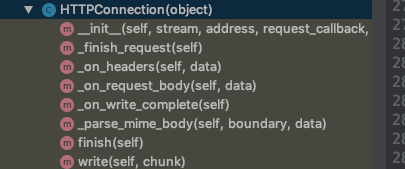

外部方法：
* [finish](#hcfinish)(self)
* [write](#hcwrite)(self, chunk)

内部方法：
* `__init__(self, stream, address, request_callback, no_keep_alive=False, xheaders=False)`
* `_finish_request(self)`
* `_on_headers(self, data)`
* `_on_request_body(self, data)`
* `_on_write_complete(self)`
* `_parse_mime_body(self, boundary, data)`

## `__init__`

HTTPConnection因为涉及到解析http报文，并执行request_callback(request)方法，所以每一个HTTPConnection对象需要有一个对应的[HTTPRequest](#HTTPRequest)对象，所以HTTPConnection内部封装了一个`_request`属性, <font color="red">然后最重要的一步到了，`self.stream.read_until("\r\n\r\n", self._header_callback)`</font>. HTTPConnection因为需要connection这个socket对象，而这个对象是被封装在[IOStream](#section_id4)里的，所以HTTPConnection对connection的操作就拜托给[IOStream](#section_id4)对象了。跳转到[IOStream](#section_id4)查看这个类的相关内容之后，HTTPConnection的构造方法把connection这个socket也交给epoll去监听，等有动静就调用[IOStream](#section_id4)的`_handle_events`.

In [7]:
class HTTPConnection(object):
    """Handles a connection to an HTTP client, executing HTTP requests.

    We parse HTTP headers and bodies, and execute the request callback
    until the HTTP conection is closed.
    """
    def __init__(self, stream, address, request_callback, no_keep_alive=False,
                 xheaders=False):
        self.stream = stream
        self.address = address
        self.request_callback = request_callback
        self.no_keep_alive = no_keep_alive
        self.xheaders = xheaders
        self._request = None
        self._request_finished = False
        # Save stack context here, outside of any request.  This keeps
        # contexts from one request from leaking into the next.
        # stack_context.wrap 这个以后再介绍
        self._header_callback = stack_context.wrap(self._on_headers)
        # 向epoll注册read事件  
        self.stream.read_until("\r\n\r\n", self._header_callback)

## `_on_headers`

HTTPConnection的主要功能是读取客户端发来的数据，并以http协议解析，生成[HTTPRequest](#HTTPRequest)对象。用python代码来实现http解析也不是很难，大概就这么几步：解析消息头，一般的get,head,delete,option类型的请求只有消息头，无消息体。如果是post或者put请求，会有消息体，主要是提交页面<form>中的表单数据，如果有上传的文件，还需要解析这上传文件数据。`_on_headers`方法，主要用于解析请求头。请求体数据格式如下：
```GET / HTTP/1.1\r\nHost: 127.0.0.1:9000\r\nConnection: keep-alive\r\nCache-Control: max-age=0\r\nUpgrade-Insecure-Requests: 1\r\nUser-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.169 Safari/537.36\r\nAccept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3\r\nAccept-Encoding: gzip, deflate, br\r\nAccept-Language: zh-CN,zh;q=0.9\r\nIf-None-Match: "4b64dd1c8f728808c8a398f603bcee9f234e29e8"\r\n\r\n```.<font color="red">有空可以看下工具类HTTPHeaders的实现</font>,[HTTPRequest](#HTTPRequest)对象这里我们需要学习一下。
    <font color="red">问题：100-continue</font>

In [ ]:
def _on_headers(self, data):
    try:
        eol = data.find("\r\n")
        start_line = data[:eol]
        try:
            # 解析第一行，获取：HTTP_METHOD, REQUEST_URI, HTTP_VERSION 
            method, uri, version = start_line.split(" ")
        ...
        # 解析请求头的剩余部分, 有空可以看下工具类HTTPHeaders的实现
        headers = httputil.HTTPHeaders.parse(data[eol:])
        self._request = HTTPRequest(
            connection=self, method=method, uri=uri, version=version,
            headers=headers, remote_ip=self.address[0])

        content_length = headers.get("Content-Length")
        # 一般 post请求 有content-length，而 get请求 只有 request header 
        if content_length:
            content_length = int(content_length)
            if content_length > self.stream.max_buffer_size:
                raise _BadRequestException("Content-Length too long")
            if headers.get("Expect") == "100-continue":
                self.stream.write("HTTP/1.1 100 (Continue)\r\n\r\n")
            # 如果有请求体就去解析请求体，然后在_on_request_body再调用self.request_callback(self._request).
            self.stream.read_bytes(content_length, self._on_request_body)
            return

        self.request_callback(self._request)
    except _BadRequestException, e:
        logging.info("Malformed HTTP request from %s: %s",
                     self.address[0], e)
        self.stream.close()
        return

## `_on_request_body`

针对POST和PUT有消息体的请求，还需要接着解析消息体.cgi.parse_qs这是个新知识点，setdefault(name, []).extend(values)这种写法也值得日后的借鉴。

In [ ]:
def _on_request_body(self, data):
    # 请求体的数据: 如post的数据在谷歌浏览器的network可以看到post_data = "name=jack&age=14"。 requests.post(url,data={"name":"jack", "age": 23})
    # 给请求request的body属性赋值
    self._request.body = data
    content_type = self._request.headers.get("Content-Type", "")
    # 根据请求体的内容类型content_type来决定怎么做请求体的数据解析
    if self._request.method in ("POST", "PUT"):
        if content_type.startswith("application/x-www-form-urlencoded"):
            arguments = cgi.parse_qs(self._request.body)
            # arguments: {'age': ['14'], 'name': ['jack']}
            for name, values in arguments.iteritems():
                # 存放的value是一个列表,因为post的data数据可能是"name=jack&name=alex&age=14"
                values = [v for v in values if v]
                if values:
                    # application/x-www-form-urlencoded 的数据存放在request.arguments 这个字典里面
                    self._request.arguments.setdefault(name, []).extend(
                        values)
        # 包含文件上传  
        elif content_type.startswith("multipart/form-data"):
            # requests.post('http://127.0.0.1:9000', files={"test": open("test.py")})
            # content_type: 'multipart/form-data; boundary=dca7e57452e927cc6255c576658070d4'
            # data: '--dca7e57452e927cc6255c576658070d4\r\n
            #        Content-Disposition: form-data; name="test.py"; filename="test.py"\r\n\r\n
            #         print(\'ok\')\n\r\n
            #        --dca7e57452e927cc6255c576658070d4--\r\n'
            fields = content_type.split(";")
            for field in fields:
                k, sep, v = field.strip().partition("=")
                if k == "boundary" and v:
                    self._parse_mime_body(v, data)
                    break
            else:
                logging.warning("Invalid multipart/form-data")
    self.request_callback(self._request)

## `_parse_mime_body`

当传输的内容是文件的时候，解析文件内容放到request.files属性中。

In [ ]:
def _parse_mime_body(self, boundary, data):
    if boundary.startswith('"') and boundary.endswith('"'):
        boundary = boundary[1:-1]
    if data.endswith("\r\n"):
        footer_length = len(boundary) + 6
    else:
        footer_length = len(boundary) + 4
    parts = data[:-footer_length].split("--" + boundary + "\r\n")
    # ['', 'Content-Disposition: form-data; name="test"; filename="test.py"\r\n\r\nprint(\'ok\')\n\r\n']
    for part in parts:
        if not part: continue
        # 传输的数据信息和数据meta是以2个换行符分割的
        eoh = part.find("\r\n\r\n")
        if eoh == -1:
            logging.warning("multipart/form-data missing headers")
            continue
        # {'Content-Disposition': ['form-data; name="test"; filename="test.py"']} 里面的parse是以 : 进行的分割
        headers = httputil.HTTPHeaders.parse(part[:eoh])
        # name_header: form-data; name="test"; filename="test.py"
        name_header = headers.get("Content-Disposition", "")
        if not name_header.startswith("form-data;") or \
           not part.endswith("\r\n"):
            logging.warning("Invalid multipart/form-data")
            continue
        # value: print(\'ok\')\n
        value = part[eoh + 4:-2]
        # 取出 name 和 filename 的值
        name_values = {}
        for name_part in name_header[10:].split(";"):
            name, name_value = name_part.strip().split("=", 1)
            name_values[name] = name_value.strip('"').decode("utf-8")
        if not name_values.get("name"):
            logging.warning("multipart/form-data value missing name")
            continue
        name = name_values["name"]
        if name_values.get("filename"):
            ctype = headers.get("Content-Type", "application/unknown")
            # 往request的files里面填充值,files 是一个字典 {'name': [{'filename': filename, 'body': value, 'content_type':content_type}]}
            self._request.files.setdefault(name, []).append(dict(
                filename=name_values["filename"], body=value,
                content_type=ctype))
        else:
            # 没有文件名则说明传输的可能不是文件，可能只是客户端借用multipart/form-data这种方式来传输数据而已
            self._request.arguments.setdefault(name, []).append(value)

## <a id="hcwrite">write</a>

从这里的write的参数chunk的意思就可以大致猜到，write这个函数可以被调用多次，发送多个chunk到socket，其实Application.flush内部就是调用了这个方法，多次通过socket把数据发送到客户端(客户端的设计一般是处于循环接收的状态)，但是socket此时并未关闭。在这里当我们每一次write一个chunk到对端，都要执行回调`_on_write_complete`: 检查[HTTPConnection](#section_id3)的属性`_request_finished`属性是否被设置成True，如果是True表明想要结束本次socket连接，执行`_finish_request`结束请求。

In [ ]:
def write(self, chunk):
    assert self._request, "Request closed"
    if not self.stream.closed():
        self.stream.write(chunk, self._on_write_complete)

## <a id="hcfinish">finish</a>

In [ ]:
def finish(self):
    assert self._request, "Request closed"
    self._request_finished = True
    if not self.stream.writing():
        self._finish_request()

## `_finish_request`

通过disconnect来判断需不需要keep_alive,如果需要说明两端的socket暂时不需要断开连接，接下来可能有http协议的交互，直接调用`self.stream.read_until("\r\n\r\n", self._header_callback)`, 如果不需要直接调用self.stream.close(): 从epoll中移除该socket描述符并close这个socket描述符。

In [ ]:
def _finish_request(self):
    # 默认no_keep_alive： False, 也就是说保持长连接，disconnect 不设置成True
    if self.no_keep_alive:
        disconnect = True
    else:
        # HTTP 1.1 一般走这个分支
        connection_header = self._request.headers.get("Connection")
        if self._request.supports_http_1_1():
            disconnect = connection_header == "close"
        elif ("Content-Length" in self._request.headers
                or self._request.method in ("HEAD", "GET")):
            disconnect = connection_header != "Keep-Alive"
        else:
            disconnect = True
    self._request = None
    self._request_finished = False
    if disconnect:
        self.stream.close()
        return
    self.stream.read_until("\r\n\r\n", self._header_callback)

# <a id="section_id4">IOStream</a>

IOStream模块封装了file-like(file or socket)的一系列非阻塞读写操作。IOStream对file-like的非阻塞读写进行了缓存，提供了读&写Buffer。当读写操作结束时<font color="red">通过callback通知上层调用者从缓存中读写数据。</font>


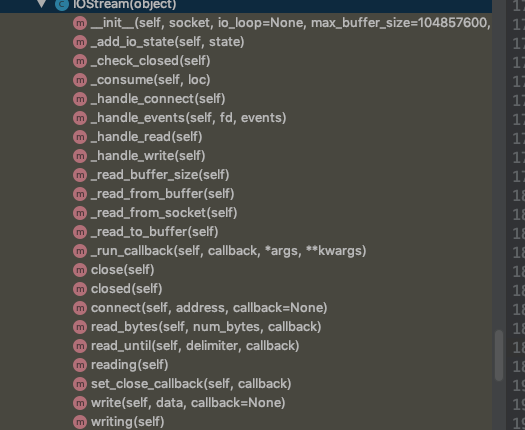

外部方法：
 - 用于socket读写的方法(核心的方法)
    * [read_bytes](#iorb)(self, num_bytes, callback): read_bytes和read_until差不多, 只不过第一个参数是读取的长度
    * [read_until](#ioru)(self, delimiter, callback): 读取的结束符和回调函数, 回调函数会把读到的数据作为参数
    * [write](#iowrite)(self, data, callback=None): 对socket的写入, 这里要注意的是并不是马上就对socket写入, 而是先写入到缓冲区, 然后改变epoll的状态, 在下一个事件循环中触发写事件再去真正的写入
 - 其他辅助型的方法
    * [connect](#ioc)(self, address, callback=None)
    * [reading](#ior)(self)
    * [writing](#iow)(self)
    * [close](#ioclose)(self)
    * [closed](#ioclosed)(self)
    * set_close_callback(self, callback)
    
内部方法：
  - 重点关注
    * `__init__(self, socket, io_loop=None, max_buffer_size=104857600, read_chunk_size=4096)`
    * `_handle_connect(self)`
    * `_handle_read(self)`
    * `_handle_write(self)`
    * `_handle_events(self, fd, events)`
    * `_read_buffer_size(self)`
    * `_read_from_buffer(self)`
    * `_read_from_socket(self)`
    * `_read_to_buffer(self)`
  - 小打小闹
    * `_add_io_state(self, state)`
    * `_check_closed(self)`
    * `_consume(self, loc)`
    * `_run_callback(self, callback, *args, **kwargs)`
    
个人觉得IOStream这个类借助[IOLoop](#IOLoop)对于socket的异步读写的这种代码设计是值得目前的我所在的阶段去学习和吸收的。如果让我自己去实现socket和[IOLoop](#IOLoop)的这种异步的读写，那么我应该怎么去设计？

In [9]:
import tornado.ioloop
import tornado.iostream
import socket

# 当connect()函数完成后，调用本函数
# 本函数在非阻塞异步写 write 后
# 异步读取以\r\n\r\n 结尾的数据，并调用回调 on_headers
def send_request():
    stream.write(b"GET / HTTP/1.0\r\nHost: www.baidu.com\r\n\r\n")
    stream.read_until(b"\r\n\r\n", on_headers)

# 当读取到以\r\n\r\n结尾的数据的时候，触发 on_headers回调函数，
# 并传入参数 data（次data数据以\r\n\r\n结尾） 到 on_headers中 
def on_headers(data):
    headers = {}
    for line in data.split(b"\r\n"):
        parts = line.split(b":")
        if len(parts) == 2:
            headers[parts[0].strip()] = parts[1].strip()
    stream.read_bytes(int(headers[b"Content-Length"]), on_body)

# 读取完header后，根据读取到的length 触发 on_body 函数，整个过程都是异步的
def on_body(data):
    print(data)
    stream.close()
    tornado.ioloop.IOLoop.instance().stop()


if __name__ == '__main__':
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM, 0)
    stream = tornado.iostream.IOStream(s)
    stream.connect(("www.baidu.com", 80), send_request)
    tornado.ioloop.IOLoop.instance().start()

## 构造方法

乍一看，我擦，构造方法里封装这么多属性，有必要吗？理解了IOstream怎么做socket的异步读写就能知道为什么需要这么多属性设置了。
首先，socket参数是必须参数，要结合[IOLoop](#IOLoop)，那么IOStream肯定也需要[IOLoop](#IOLoop)实例用于注册事件描述符，除此之外还有异步读写的两个关键的buffer队列以及队列的最大大小(默认100M), 4个回调函数(`_read_callback`, `_write_callback`, `_connect_callback`, `_close_callback`)，配合read系列的两个函数的`_read_delimiter`和`_read_bytes`.最后在构造方法里进行了socket的事件注册, 只不过这里注册的事件既不是read也不是write.真正注册read还是write取决于调用IOStream的read系列还是write系列，在read系列中会注册read事件，在write系列中会注册write事件。先用上面的例子去看IOStream的流程，然后在回过头看[HTTPConnection](#HTTPConnection)里的iostream.

In [10]:
def __init__(self, socket, io_loop=None, max_buffer_size=104857600,
             read_chunk_size=4096):
    self.socket = socket
    self.socket.setblocking(False)
    self.io_loop = io_loop or ioloop.IOLoop.instance()
    self.max_buffer_size = max_buffer_size
    self.read_chunk_size = read_chunk_size
    self._read_buffer = collections.deque()
    self._write_buffer = collections.deque()
    self._write_buffer_frozen = False
    self._read_delimiter = None # 读取的结束符 http中是\r\n\r\n
    self._read_bytes = None # 读取的长度, 当http协议是post时, 按照Content-Length来读取body内容
    self._read_callback = None #读回调
    self._write_callback = None # 写回调
    self._close_callback = None  # 关闭socket的回调
    self._connect_callback = None # 发送连接成功的回调
    self._connecting = False # 标识是否已经发送了连接请求
    self._state = self.io_loop.ERROR
    with stack_context.NullContext():
        # _handle_events是读和写都会回调统一的,默认注册的回到是错误状态
        self.io_loop.add_handler(
            self.socket.fileno(), self._handle_events, self._state)

## <a id="ioc">connect</a>

connect用于把请求发送出去，然后修改之前的socket的监听事件为write，当tcp三次握手连接建立成功之后，socket就变为可写状态, 然后在ioloop的start的时候会走到[IOStream](#section_id4)的`_handle_events`总入口。

In [12]:
def connect(self, address, callback=None):
    """Connects the socket to a remote address without blocking.
    """
    self._connecting = True
    try:
        self.socket.connect(address)
    except socket.error, e:
        # In non-blocking mode connect() always raises an exception
        if e.args[0] not in (errno.EINPROGRESS, errno.EWOULDBLOCK):
            raise
    self._connect_callback = stack_context.wrap(callback)
    self._add_io_state(self.io_loop.WRITE)

## `_handle_events`

`_handle_events` 作为上层[IOLoop](#IOLoop)的add_handle()的参数，传递到[IOLoop](#IOLoop)中检测事件发生后回调此函数，READ , WRIET , ERROR 事件都采用这个统一的回调

In [13]:
def _handle_events(self, fd, events):
    #epoll第一阶段调用回调的过程中，会将事件类型和fd统一的传入函数
    #见 IOLoop.py 中 start()函数
    if not self.socket:
        logging.warning("Got events for closed stream %d", fd)
        return
    try:
        if events & self.io_loop.READ:
            self._handle_read()
        if not self.socket:
            return
        if events & self.io_loop.WRITE:
            # 这里的 connecting 标志位： 在服务端的话是不需要此标志位的
            if self._connecting:
                self._handle_connect()
            self._handle_write()
        if not self.socket:
            return
        if events & self.io_loop.ERROR:
            self.close()
            return
        state = self.io_loop.ERROR
        #如果没有读取完 还需要继续监听READ事件,
        #如果没有_read_bytes或者_read_delimiter, 则不需要监听读事件
        #这两个值都是外部调用read和write函数时用的
        #在程序运行中其实不太可能存在读写都有的时候,如果真有那么可能程序的逻辑有问题了
        #对于_read_delimiter和_read_bytes也是几乎不会同时存在的
        """
        if self._read_delimiter or self._read_bytes:
            state |= self.io_loop.READ
        if self._write_buffer:
            state |= self.io_loop.WRITE
        if state != self._state:
            self._state = state
            self.io_loop.update_handler(self.socket.fileno(), self._state)
        """
        if self.reading():
            state |= self.io_loop.READ
        if self.writing():
            state |= self.io_loop.WRITE
        if state != self._state:
            self._state = state
            self.io_loop.update_handler(self.socket.fileno(), self._state)
    except:
        logging.error("Uncaught exception, closing connection.",
                      exc_info=True)
        self.close()
        raise

## reading and writing

reading：想要从socket读取的数据在一次[IOLoop](#IOLoop)循环中没有读完，所以是"正在读"
writing：想要从socket发送的数据在一次[IOLoop](#IOLoop)循环中没有发完，所以是"正在写"

In [14]:
def reading(self):
    """Returns true if we are currently reading from the stream."""
    return self._read_callback is not None

def writing(self):
    """Returns true if we are currently writing to the stream."""
    return bool(self._write_buffer)

## `_handle_connect`

能走到这个方法，说明socket的状态是可以发送http请求报文，接下来我们应该执行我们自定义的send_request方法了。我们看到send_request执行了2行代码：[write](#write)以及[read_until](#read_until)。涉及到2个核心方法：<font color="red">write和read_until, 且这两个涉及socket的方法是异步的.</font>

In [15]:
def _handle_connect(self):
    if self._connect_callback is not None:
        callback = self._connect_callback
        self._connect_callback = None
        self._run_callback(callback)
    # self._connecting 置为False, 在_handle_events里self.io_loop.WRITE条件只会执行_handle_write，不会执行_handle_connect
    self._connecting = False

## <a id="iowrite">write</a>

对socket的写入, 这里要注意的是并不是马上就对socket写入, 而是先写入到缓冲区, 然后改变epoll的状态, 设置写回调函数，在下一个事件循环中触发写事件再去真正的写入，等真正的写入完毕会去调用写回调函数。

In [16]:
def write(self, data, callback=None):
    """Write the given data to this stream.
    """
    # 添加数据到写缓冲区里面, 并且改变监听事件为写事件,
    # 在下一个事件循环中触发写事件将缓冲区中的内容写到文件描述符中
    self._check_closed()
    self._write_buffer.append(data)
    self._add_io_state(self.io_loop.WRITE)
    self._write_callback = stack_context.wrap(callback)

## <a id="ioru">read_until</a>

先从缓存中查找结束符, 如果查不到需要添加监听读事件, 读取数据之后再次从缓存中去取数据, 这是一个循环的过程, 从缓存中找不到数据就扩充缓存，直到找到数据为止。我们可以来考虑一下这个怎么实现：设置读取内容成功之后的回调函数是不可缺少的, 然后设置一个while循环, 第一步是先从缓存中读取数据(有可能上一次从socket读取的那么些数据中已经有想要数据，直接取即可)，如果能拿到包含`_read_delimiter`的数据就退出方法，如果从缓存中拿不到数据则试着从socket中每一次读取read_chunk_size大小的数据到缓冲区，但是这里有一个问题是你想去从这个socket读数据而这个socket就立马能满足你read的条件吗？所以如果`_read_to_buffer`返回0我们可以先假定就是socket还没准备好，此时应该退出循环，并让epoll帮我们查看socket是否可读。第一回合`read_until`并没有读取到任何内容，仅仅做的事就是把read加入事件回调。此时send_request函数执行完毕了，总结一下就2件事，把数据写到缓冲区和注册了一个read事件。接下来会执行`_handle_evnets`的[`_handle_write`](#`_handle_write`)方法了。


In [17]:
def read_until(self, delimiter, callback):
    """Call callback when we read the given delimiter."""
    # 只有上一次需要完成的read执行完毕才能再次调用这个方法
    assert not self._read_callback, "Already reading"
    self._read_delimiter = delimiter
    self._read_callback = stack_context.wrap(callback)
    while True:
        # See if we've already got the data from a previous read
        if self._read_from_buffer():
            return
        self._check_closed()
        if self._read_to_buffer() == 0:
            break
    self._add_io_state(self.io_loop.READ)

## `_read_to_buffer`

`_read_to_buffer`主要完成的功能从socket中读取数据并放到缓冲区，返回读取到的数据的长度。这个方法的关注点在于把数据放到缓冲区，至于从socket读取数据的那几行代码就放到[`_read_from_socket`](#_read_from_socket). 返回0或者读取的数据长度，当返0表示socket还没有准备好或者对端连接已经关闭，返回非0就把读取到的数据放到缓冲区内。

In [19]:
def _read_to_buffer(self):
    """Reads from the socket and appends the result to the read buffer.

    Returns the number of bytes read.  Returns 0 if there is nothing
    to read (i.e. the read returns EWOULDBLOCK or equivalent).  On
    error closes the socket and raises an exception.
    """
    try:
        chunk = self._read_from_socket()
    except socket.error, e:
        # ssl.SSLError is a subclass of socket.error
        logging.warning("Read error on %d: %s",
                        self.socket.fileno(), e)
        self.close()
        raise
    if chunk is None:
        return 0
    self._read_buffer.append(chunk)
    if self._read_buffer_size() >= self.max_buffer_size:
        logging.error("Reached maximum read buffer size")
        self.close()
        raise IOError("Reached maximum read buffer size")
    return len(chunk)

## <a id="_read_from_socket">`_read_from_socket`</a>

<font color="red">尝试</font>从socket中去读取数据(因为调用这个方法的时候socket不一定是可读的).返回读取到的数据或None。有2种情况会返回None, 一种是socket并没有准备好，另一种是对端的socket关闭连接了，这种情况会关闭socket(这就是为啥在[IOStream](#section_id4)中的很多方法都要check socket, 因为对端可能因为某些异常或其他原因关闭了socket，那么包含对应socket的[IOStream](#section_id4)也应该不能按照正常逻辑去工作，需要做判断再做决定)并返回None.

In [21]:
def _read_from_socket(self):
    """Attempts to read from the socket.

    Returns the data read or None if there is nothing to read.
    May be overridden in subclasses.
    """
    try:
        chunk = self.socket.recv(self.read_chunk_size)
    except socket.error, e:
        if e.args[0] in (errno.EWOULDBLOCK, errno.EAGAIN):
            return None
        else:
            raise
    if not chunk:
        self.close()
        return None
    return chunk

## <a id="`_handle_write`">`_handle_write`</a>

写函数很简单, 循环着把队列`_write_buffer`中的数据全部写到socket即可, 当全部写完之后如果有`_write_callback`就调用这个回调(在这个例子中没有这个回调, socket数据全部发送完毕接下来并不需要做什么工作), 这样`_handle_events`就执行完毕了。因为read_until调用的时候注册了read事件，那么下一次事件循环就会执行`_handle_events`的`_handle_read`方法。

In [23]:
def _handle_write(self):
    while self._write_buffer:
        try:
            if not self._write_buffer_frozen:
                _merge_prefix(self._write_buffer, 128 * 1024)
            #将buffer链的数据一并发出去
            num_bytes = self.socket.send(self._write_buffer[0])
            self._write_buffer_frozen = False
            _merge_prefix(self._write_buffer, num_bytes)
            self._write_buffer.popleft()
        except socket.error, e:
            if e.args[0] in (errno.EWOULDBLOCK, errno.EAGAIN):
                #这里的套接口写过程当中如果遇到了不可写的情况，会先停止
                #但是此时未发送的buffer 的数据任然在，所以不会导致数据丢失
                #因为在发送的时候是有多少发送多少，因为在负责不大的情况下，套接口
                #是一直可写的，所以 epoll返回的都是可写状态
                self._write_buffer_frozen = True
                break
            else:
                logging.warning("Write error on %d: %s",
                                self.socket.fileno(), e)
                self.close()
                return
    #如果有 wriet_callback 则调用相应的回调函数
    if not self._write_buffer and self._write_callback:
        callback = self._write_callback
        self._write_callback = None
        self._run_callback(callback)

## `_handle_read`

socket可读的事件处理方法，是一个死循环，想要达到的目标是从buffer读到想要的(分为截止符和字节数两种情况)。重点是[`_read_from_buffer`](#_read_from_buffer)。这个函数是在_handle_events中被调用的,当描述符可读后，统一采取统一的方式读取,此时的 fd 作为类的全局变量，所以在调用 `_read_to_buffer()`的时候不需要传递这个参数,`_read_to_buffer()` 是类方法，将从 socket 中读取的数据读入 buffer 中,其中`_read_to_buffer()` 会调用 `_read_from_socket` 然后将数据转储到 buffer中统一管理.

In [ ]:
def _handle_read(self):
    while True:
        try:
            #从socket读取数据到本地buffer
            #此同步调用其实是因为在这里的上层函数 _handle_read是异步被回调的
            #所以这里能够确定此时的 socket 是可读的
            result = self._read_to_buffer()
        except Exception:
            self.close()
            return
        if result == 0:
            break
        else:
            #在处理完数据并将数据通过一系列处理后，调用_read_from_buffer()将数据从buffer
            #中取出，然后回调 read_bytes()或者是 read_untils() 中的回调函数
            if self._read_from_buffer():
                return

## <a id="_read_from_buffer">`_read_from_buffer`</a> 

`_read_from_buffer`可以根据条件处理read_until和read_bytes中设置给[IOStream](#section_id4)的2个条件`_read_bytes`和`_read_delimiter`。`self._run_callback`执行callback函数，并把寻找到的数据data作为参数传给callback

In [ ]:
def _read_from_buffer(self):
    if self._read_bytes:
        # 如果当前缓存长度大于等于给定的读取长度 说明已经读取完毕
        # 触发回调函数 清空_read_bytes  _read_callback变量
        if self._read_buffer_size() >= self._read_bytes:
            num_bytes = self._read_bytes
            callback = self._read_callback
            self._read_callback = None
            self._read_bytes = None
            self._run_callback(callback, self._consume(num_bytes))
            return True
    elif self._read_delimiter:
        # 如果调用了read_until则查找缓冲区的_read_delimiter如果没有则继续等待
        # sys.maxint: 9223372036854775807  很大很大，相当于从_read_buffer队列中所有的数据中查找_read_delimiter
        _merge_prefix(self._read_buffer, sys.maxint)
        loc = self._read_buffer[0].find(self._read_delimiter)
        if loc != -1:
            callback = self._read_callback
            delimiter_len = len(self._read_delimiter)
            self._read_callback = None
            self._read_delimiter = None
            self._run_callback(callback,
                               self._consume(loc + delimiter_len))
            return True
    return False

## `_run_callback` 

In [ ]:
def _run_callback(self, callback, *args, **kwargs):
    try:
        # Use a NullContext to ensure that all StackContexts are run
        # inside our blanket exception handler rather than outside.
        with stack_context.NullContext():
            callback(*args, **kwargs)
    except:
        ...

## `_read_buffer_size`

统计buffer的大小, 虽然仅仅只有一行代码, 而且被调用的地方只有一处, 但还是被封装成了一个方法。因为这样既可以在调用方仅关注调用方的功能，减少不必要的额外的逻辑，再来谁也不确定这个功能以后会不会被调用第二次。

In [24]:
def _read_buffer_size(self):
    return sum(len(chunk) for chunk in self._read_buffer)

## `_consume`

In [26]:
def _consume(self, loc):
    _merge_prefix(self._read_buffer, loc)
    return self._read_buffer.popleft()

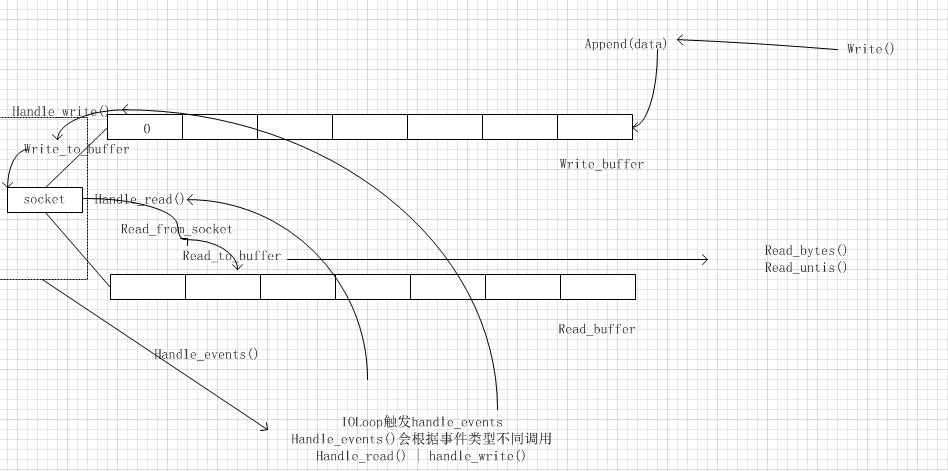

# <a id="HTTPRequest">HTTPRequest</a>

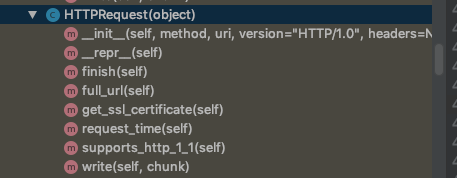
外部方法:
* [write](#hrwrite)(self, chunk)
* [finish](#hrfinish)(self)
* [full_url](#hrfu)(self)
* [request_time](#hrrt)(self)
* [supports_http_1_1](#hsh)(self)

内部方法:
* `__init__(self, method, uri, version="HTTP/1.0", headers=None, body=None, remote_ip=None, protocol=None, host=None,files=None, connection=None)`
* `__repr__(self)`

HTTPRequest内置的类说明已经把这个工具类的情况做了大致说明：GET/POST的参数放在arguments属性中；文件上传放在files属性中；一个HTTPRequrest对象对应一个[HTTPConnection](#section_id3)对象。在[HTTPConnection](#section_id3)中是这样调用的：`self._request = HTTPRequest(connection=self, method=method, uri=uri, version=version, headers=headers, remote_ip=self.address[0])`。传入到构造方法里的有[HTTPConnection](#section_id3), 请求方法、url、http版本，客户端地址，请求头等信息。

"""
A single HTTP request.

GET/POST arguments are available in the arguments property, which
maps arguments names to lists of values (to support multiple values
for individual names). Names and values are both unicode always.

File uploads are available in the files property, which maps file
names to list of files. Each file is a dictionary of the form
{"filename":..., "content_type":..., "body":...}. The content_type
comes from the provided HTTP header and should not be trusted
outright given that it can be easily forged.

An HTTP request is attached to a single HTTP connection, which can
be accessed through the "connection" attribute. Since connections
are typically kept open in HTTP/1.1, multiple requests can be handled
sequentially on a single connection.

"""

## 构造方法

<font color="red">urlparse.urlsplit是一个新知识点</font>. 我们想象一下[HTTPRequest](#HTTPRequest)应该包含哪些属性：
* method
* headers
* body
* files
* host
* path
* query
* arguments

除了这些我们可以想到的，还有如下属性：
* version
* connection
* `_start_time`
* `_finish_time`

In [27]:
def __init__(self, method, uri, version="HTTP/1.0", headers=None,
             body=None, remote_ip=None, protocol=None, host=None,
             files=None, connection=None):
    self.method = method
    # uri: /index?age=12&name=jack
    self.uri = uri
    self.version = version
    self.headers = headers or httputil.HTTPHeaders()
    self.body = body or ""
    ...
    # self.host: 127.0.0.1:9000
    self.host = host or self.headers.get("Host") or "127.0.0.1"
    self.files = files or {}
    self.connection = connection
    self._start_time = time.time()
    self._finish_time = None

    scheme, netloc, path, query, fragment = urlparse.urlsplit(uri)
    self.path = path
    self.query = query
    arguments = cgi.parse_qs(query)
    self.arguments = {}
    for name, values in arguments.iteritems():
        values = [v for v in values if v]
        if values: self.arguments[name] = values

## <a id="hrfu">full_url</a>

重新构造出客户端发送的url地址

In [28]:
def full_url(self):
    """Reconstructs the full URL for this request."""
    return self.protocol + "://" + self.host + self.uri

## <a id="hrrt">request_time</a>

用于记录一次请求的时机长短

In [29]:
def request_time(self):
    """Returns the amount of time it took for this request to execute."""
    if self._finish_time is None:
        return time.time() - self._start_time
    else:
        return self._finish_time - self._start_time

## <a id="hsh">supports_http_1_1</a>

该请求是否支持HTTP1.1，也就是是否支持keep-alive长连接。

In [30]:
def supports_http_1_1(self):
    """Returns True if this request supports HTTP/1.1 semantics"""
    return self.version == "HTTP/1.1"

`self.request_callback(self._request)`：在调用Application的对象的时候传的参数是[HTTPRequest](#HTTPRequest), 虽然说[HTTPConnection](#section_id3)是处理HTTP请求的，但是这个类做的解析http报文这种"黑活"还是不要让用户知道为好，相反HTTPRequest对象才是从感官上最贴近用户的。所以在server端，返回响应和结束请求都是通过[HTTPRequest](#HTTPRequest)来做，但是[HTTPRequest](#HTTPRequest)本身并不是做这2件事的，所以它在构造方法里接收[HTTPConnection](#section_id3)对象，用这个对象去返回响应和结束请求。

## <a id="hrfinish">finish</a>

结束请求并记录结束时间

In [31]:
def finish(self):
    """Finishes this HTTP request on the open connection."""
    self.connection.finish()
    self._finish_time = time.time()

## <a id="hrwrite">write</a>

发送数据到响应流里, 接收的参数必须是字符串.

In [1]:
def write(self, chunk):
    """Writes the given chunk to the response stream."""
    assert isinstance(chunk, str)
    self.connection.write(chunk)

# <a id="RequestHandler">RequestHandler</a>

RequestHandler是提供给用户来继承的业务类，里面封装了很多很多方法，用于处理web框架比较普遍的一些功能，比如cookie的管理、xsrf攻击等。这个对象构造方法需要的参数有2个是需要关注的：application, request。不考虑额外的功能，构造方法 + `_execute` 就能完成最基本的web业务逻辑了.

## 构造方法

RequestHandler具有的属性：
* application
* request
* `_headers_written`
* `_finished`
* `_auto_finish`
* `_transforms`
* `_headers`
* `_status_code`
* `_write_buffer`
* ...

在构造方法里还调用了`self.initialize(**kwargs)`: initialize应该只把传入的参数保存在自身的成员变量中，而不应该提供任何的输出或调用如send_error等方法。


In [2]:
class RequestHandler(object):
    """Subclass this class and define get() or post() to make a handler.

    If you want to support more methods than the standard GET/HEAD/POST, you
    should override the class variable SUPPORTED_METHODS in your
    RequestHandler class.
    """
    SUPPORTED_METHODS = ("GET", "HEAD", "POST", "DELETE", "PUT", "OPTIONS")

    def __init__(self, application, request, **kwargs):
        self.application = application
        self.request = request
        self._headers_written = False
        self._finished = False
        self._auto_finish = True
        self._transforms = None  # will be set in _execute
        ...
        self.clear()
        # Check since connection is not available in WSGI
        if hasattr(self.request, "connection"):
            self.request.connection.stream.set_close_callback(
                self.on_connection_close)
        self.initialize(**kwargs)

## clear

把response的header和content重置

In [3]:
def clear(self):
    """Resets all headers and content for this response."""
    self._headers = {
        "Server": "TornadoServer/%s" % tornado.version,
        "Content-Type": "text/html; charset=UTF-8",
    }
    if not self.request.supports_http_1_1():
        if self.request.headers.get("Connection") == "Keep-Alive":
            self.set_header("Connection", "Keep-Alive")
    self._write_buffer = []
    self._status_code = 200

## `_execute`

prepare 方法要结合 `_execute` 和 finish 来理解。从前面分析的流程中，`_execute` 是 RequestHandler 被调用的入口，它首先调用了 prepare()，并且会判断 `self._finished` 标记，而后才执行 get / post 。只要我们 override prepare()，并且调用 finish() 就可以阻断 get / post 的执行。这个可以用来做缓存或者其他前置处理。

In [4]:
def _execute(self, transforms, *args, **kwargs):
    """Executes this request with the given output transforms."""
    self._transforms = transforms
    with stack_context.ExceptionStackContext(
        self._stack_context_handle_exception):
        if self.request.method not in self.SUPPORTED_METHODS:
            raise HTTPError(405)
        # If XSRF cookies are turned on, reject form submissions without
        # the proper cookie, 这里判断method是post、put等才进行校验
        if self.request.method not in ("GET", "HEAD") and \
           self.application.settings.get("xsrf_cookies"):
            self.check_xsrf_cookie()
        self.prepare()
        if not self._finished:
            getattr(self, self.request.method.lower())(*args, **kwargs)
            # 如果用使用asynchronous修饰, 则_auto_finsh为false不自动结束, 等着别的用户在别的自定义方法里去调用self.finish()
            if self._auto_finish and not self._finished:
                self.finish()

In [5]:
class TestHandler(RequestHandler):
    def prepare(self):
        # 判断缓存是否过期 (此处暂略)
        self.write("cache\n")
        self.finish()

    def get(self):
        self.write("Hello, World!\n")


## write

write方法是后端向前端页面直接展示的方法。从上述源码中可以看出，write方法接收字典和字符串类型的参数，如果用户传来的数据是字典类型，源码中会自动用json对字典进行序列化，最终序列化成字符串。

`self._write_buffer`是源码中定义的一个临时存放需要输出的字符串的地方，是列表格式。需要write的内容添加到 `self._write_buffer`后，系统会执行flush方法.

In [6]:
def write(self, chunk):
    """Writes the given chunk to the output buffer.

    To write the output to the network, use the flush() method below.

    If the given chunk is a dictionary, we write it as JSON and set
    the Content-Type of the response to be text/javascript.

    Note that lists are not converted to JSON because of a potential
    cross-site security vulnerability.  All JSON output should be
    wrapped in a dictionary.  More details at
    http://haacked.com/archive/2008/11/20/anatomy-of-a-subtle-json-vulnerability.aspx
    """
    assert not self._finished
    if isinstance(chunk, dict):
        chunk = escape.json_encode(chunk)
        self.set_header("Content-Type", "text/javascript; charset=UTF-8")
    chunk = _utf8(chunk)
    self._write_buffer.append(chunk)

## finish

主要关注self.flush(include_footers=True)以及self.request.finish()。

In [7]:
def finish(self, chunk=None):
    """Finishes this response, ending the HTTP request."""
    assert not self._finished
    if chunk is not None: self.write(chunk)
    if not self._headers_written:
        if (self._status_code == 200 and
            self.request.method in ("GET", "HEAD") and
            "Etag" not in self._headers):
            hasher = hashlib.sha1()
            for part in self._write_buffer:
                hasher.update(part)
            etag = '"%s"' % hasher.hexdigest()
            inm = self.request.headers.get("If-None-Match")
            if inm and inm.find(etag) != -1:
                self._write_buffer = []
                self.set_status(304)
            else:
                self.set_header("Etag", etag)
        if "Content-Length" not in self._headers:
            content_length = sum(len(part) for part in self._write_buffer)
            self.set_header("Content-Length", content_length)

    if hasattr(self.request, "connection"):
        # Now that the request is finished, clear the callback we
        # set on the IOStream (which would otherwise prevent the
        # garbage collection of the RequestHandler when there
        # are keepalive connections)
        self.request.connection.stream.set_close_callback(None)

    if not self.application._wsgi:
        # 将处理请求返回的数据发送到IOStream的_write_buffer队列中
        self.flush(include_footers=True)
        self.request.finish()
        self._log()
    self._finished = True

## flush

将处理请求返回的数据发送到[IOStream](#section_id4)的_write_buffer队列中，那么这个功能为啥不直接调用self.request.write(headers + chunk)而是封装成一个flush方法呢？因为在这个flush方法里要完成headers和transform的一些功能。flush可以在RequestHandler中被调用多次，既然是调用多次，那么这里涉及到一个问题，响应数据可以发送到`_write_buffer`多次，但是响应头按理说只可以有一份，那么通过什么来标识在每次调用flush的时候要不要产生headers呢？这里通过`self._headers_written`属性来标识，

In [8]:
def flush(self, include_footers=False):
    """Flushes the current output buffer to the network."""
    if self.application._wsgi:
        raise Exception("WSGI applications do not support flush()")

    chunk = "".join(self._write_buffer)
    self._write_buffer = []
    if not self._headers_written:
        self._headers_written = True
        for transform in self._transforms:
            self._headers, chunk = transform.transform_first_chunk(
                self._headers, chunk, include_footers)
        headers = self._generate_headers()
    else:
        for transform in self._transforms:
            # include_footers 表示是否包含是结束状态，拿ChunkedTransferEncoding来说，结束状态需要在默认添加 0\r\n\r\n 
            chunk = transform.transform_chunk(chunk, include_footers)
        headers = ""

    # Ignore the chunk and only write the headers for HEAD requests
    if self.request.method == "HEAD":
        if headers: self.request.write(headers)
        return

    if headers or chunk:
        self.request.write(headers + chunk)

## `_generate_headers`

用于生成响应头，我们可以考虑一下，生成的响应头应该包含一些什么内容呢？`self._headers`加上cookie

In [9]:
def _generate_headers(self):
    lines = [self.request.version + " " + str(self._status_code) + " " +
             httplib.responses[self._status_code]]
    lines.extend(["%s: %s" % (n, v) for n, v in self._headers.iteritems()])
    for cookie_dict in getattr(self, "_new_cookies", []):
        for cookie in cookie_dict.values():
            lines.append("Set-Cookie: " + cookie.OutputString(None))
    return "\r\n".join(lines) + "\r\n\r\n"

## <a id="ChunkedTransferEncoding">ChunkedTransferEncoding</a>

ChunkedTransferEncoding: 传输编码成chunk. 要想理解这个，得有一些基础的http协议的知识

### transfer-encoding和content-encoding

transfer-encoding的可选值有：chunked,identity，从字面意义可以理解，前者指把要发送传输的数据切割成一系列的块数据传输，后者指传输时不做任何处理，自身的本质数据形式传输。举个例子，如果我们要传输一本“红楼梦”小说到服务器，chunked方式就会先把这本小说分成一章一章的，然后逐个章节上传，而identity方式则是从小说的第一个字按顺序传输到最后一个字结束。

Content-Encoding ： content-encoding和transfer-encoding所作用的对象不同，行为目标也不同，前者是对数据内容采用什么样的编码方式，后者是对数据传输采用什么样的编码。前者通常是对数据内容进行一些**压缩编码**操作，后者通常是对传传输采用**分块策略**之类的。

### content-length和transfer-encoding
Content-length: content-length头的作用是指定待传输的内容的字节长度。比如上面举的例子中，我们要上传一本红楼梦小说，则可以指定其长度大小，如：content-length:731017。那么它和transfer-encoding又有什么关系呢？如果想知道它们的关系，只要反过来问下自己，为什么transfer-encoding会有identity和chunked两种，各在什么上下文情景中要用到。比如chunked方式，把数据分块传输在很多地方就非常有用，如服务端在处理一个复杂的问题时，其返回结果是阶段性的产出，所以服务端不能一次性知道最终的返回的总长度(content-lenght值)，所以这时候返回头中就不能有content-lenght头信息，有也要忽略处理。所以你可以这样理解，transfer-encoding在不能一次性确定消息实体(entity)内容时自定义一些传输协议，如果能确定的话，则可以在消息头中加入content-length头信息指示其长度，可以把transfer-encoding和content-length看成互斥性的两种头。
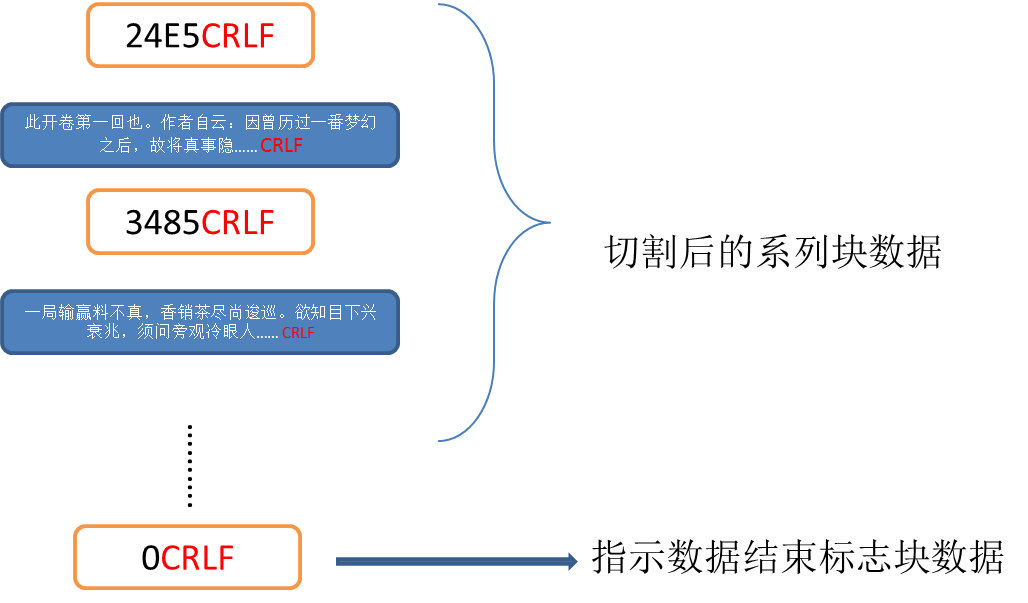

分块编码主要应用于如下场景，即要传输大量的数据，但是在请求在没有被处理完之前响应的长度是无法获得的。例如，当需要用从数据库中查询获得的数据生成一个大的HTML表格的时候，或者需要传输大量的图片的时候。一个分块响应形式如下：
```
HTTP/1.1 200 OK 
Content-Type: text/plain 
Transfer-Encoding: chunked

7\r\n
Mozilla\r\n 
9\r\n
Developer\r\n
7\r\n
Network\r\n
0\r\n 
\r\n
```

tornado中ChunkedTransferEncoding是在flush数据到socket的时候，把`_write_buffer`的数据整合到一起称为一次chunk，然后对这个chunk进行Chunked操作并设置响应头. 而且我们发现这里的ChunkedTransferEncoding的方法都没有使用循环去不断压缩chunk, 其实循环的过程取决于flush多少次，如果仅仅是flush一次一个很大的数据，那么我认为这里的压缩并没有太大含义了。

In [ ]:
class ChunkedTransferEncoding(OutputTransform):
    """Applies the chunked transfer encoding to the response.
    """
    def __init__(self, request):
        # http1.1 支持chunk
        self._chunking = request.supports_http_1_1()

    def transform_first_chunk(self, headers, chunk, finishing):
        if self._chunking:
            # No need to chunk the output if a Content-Length is specified
            if "Content-Length" in headers or "Transfer-Encoding" in headers:
                self._chunking = False
            else:
                headers["Transfer-Encoding"] = "chunked"
                chunk = self.transform_chunk(chunk, finishing)
        return headers, chunk

    def transform_chunk(self, block, finishing):
        if self._chunking:
            # Don't write out empty chunks because that means END-OF-STREAM
            # with chunked encoding
            if block:
                block = ("%x" % len(block)) + "\r\n" + block + "\r\n"
            if finishing:
                block += "0\r\n\r\n"
        return block

# GZipContentEncoding

和ChunkedTransferEncoding不同，这个类是对response的内容进行gzip压缩，不是针对传输。这里的压缩也是一部分一部分的压缩，采用的方式是`_gzip_pos`记录上一次取的值的位置。

In [ ]:
class GZipContentEncoding(OutputTransform):
    """Applies the gzip content encoding to the response.
    """
    CONTENT_TYPES = set([
        "text/plain", "text/html", "text/css", "text/xml",
        "application/x-javascript", "application/xml", "application/atom+xml",
        "text/javascript", "application/json", "application/xhtml+xml"])
    MIN_LENGTH = 5

    def __init__(self, request):
        self._gzipping = request.supports_http_1_1() and \
            "gzip" in request.headers.get("Accept-Encoding", "")

    def transform_first_chunk(self, headers, chunk, finishing):
        if self._gzipping:
            ctype = headers.get("Content-Type", "").split(";")[0]
            self._gzipping = (ctype in self.CONTENT_TYPES) and \
                (not finishing or len(chunk) >= self.MIN_LENGTH) and \
                (finishing or "Content-Length" not in headers) and \
                ("Content-Encoding" not in headers)
        if self._gzipping:
            headers["Content-Encoding"] = "gzip"
            self._gzip_value = cStringIO.StringIO()
            self._gzip_file = gzip.GzipFile(mode="w", fileobj=self._gzip_value)
            self._gzip_pos = 0
            chunk = self.transform_chunk(chunk, finishing)
            if "Content-Length" in headers:
                headers["Content-Length"] = str(len(chunk))
        return headers, chunk

    def transform_chunk(self, chunk, finishing):
        if self._gzipping:
            self._gzip_file.write(chunk)
            if finishing:
                self._gzip_file.close()
            else:
                self._gzip_file.flush()
            chunk = self._gzip_value.getvalue()
            if self._gzip_pos > 0:
                chunk = chunk[self._gzip_pos:]
            self._gzip_pos += len(chunk)
        return chunk

# <a id="IOLoop">IOLoop</a>

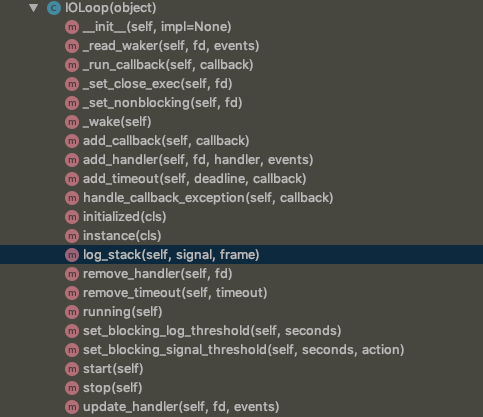

个人觉得比较重要的几个外部方法是:
* add_callback(self, callback)
* add_handler(self, fd, handler, events)
* remove_handler(self, fd)
* add_timeout(self, deadline, callback)
* remove_timeout(self, timeout)
* instance(cls)
* start(self)
* stop(self)

事件循环可以说是tornado的核心，但是仅仅对使用tornado的用户来说可能不太需要关注这个。但是如果是为了更深地去理解torndao的原理以及今后应付面试，这一块还是需要掌握的。

有2个问题：
1. epoll的ET和LT分别是什么
2. 为什么IO多路复用常常和非阻塞IO结合在一起


tornado有四类异步事件：立即事件，定时器异步事件，io异步事件，Future异步事件。

tornado 的ioloop管理所有的异步事件，并在适当的时机调用异步事件的回掉函数。

四类异步事件均在ioloop的start函数中调度。

立即事件：
场景：当前函数执行完后，下次ioloop调度时直接调度某函数
用法：ioloop.add_callback(callback, *args, **kwargs)
原理：立即事件全部存放在ioloop._callbacks中，IOLoop每次循环都会调用这些立即事件的回调函数

定时器异步事件：
场景：用户希望在某一段时间后执行某函数
用法：ioloop.call_at(when, callback, *args, **kwargs), ioloop.call_later(delay, callback, *args, **kwargs)(1.2版本中是add_timeout)
原理：定时器事件存放在ioloop._timeouts中，IOLoop每次循环开始都会找出所有已经超时的定时器，并调用对应的回调函数

IO异步事件：
场景：等待某个文件描述符的某个事件，如TCPserver等待socket的READ事件
用法：ioloop.add_handler(fd, callback, events)
原理：所有的文件描述符全部存放在ioloop._impl中，windows平台下_impl是tornado.platform.select.SelectIOLoop对象，在linux平台下_impl是tornado.platform.epoll.EPollIOLoop对象，作用都是同时监听多个文件描述符

Future异步事件：
场景：等待某个异步事件结束后执行回掉函数
用法：ioloop.add_future(future, callback)， future.add_done_callback(callback)
原理：异步事件结束后调用Future.set_result()，当执行set_result时将future所有的回掉函数添加为ioloop的立即事件
```
class Future(object):
    def set_result(self, result):
        self._result = result
        self._set_done()
        
    def _set_done(self):
        self._done = True
        if self._callbacks:
            from tornado.ioloop import IOLoop
            loop = IOLoop.current()
            for cb in self._callbacks:
                loop.add_callback(cb, self) #将所有的回掉函数设置为ioloop的立即事件
            self._callbacks = None
```

## ET 和 LT

LT(水平触发): 缺省的工作方式，并且同时支持block和no-block socket.在这种做法中，内核告诉你一个文件描述符是否就绪了，然后你可以对这个就绪的fd进行IO操作。如果你不作任何操作，内核还是会继续通知你的，所以，<font color="red">这种模式编程出错误可能性要小一点。</font>传统的select/poll都是这种模型的代表．
ET(边沿触发): 高速工作方式，只支持no-block socket。在这种模式下，当描述符从未就绪变为就绪时，内核通过epoll告诉你。然后它会假设你知道文件描述符已经就绪，并且不会再为那个文件描述符发送更多的就绪通知. 

如果使用水平触发模式，当内核通知文件描述符可读写时，接下来可以继续去检测它的状态，看它是否依然可读或可写。所以在收到通知后，没必要一次执行尽可能多的读写操作。

如果使用边沿触发模式，I/O事件发生时才会有通知，只有另一个I/O事件到来时才会收到新的通知。由于我们不知道到底能读写多少数据，所以在收到通知后应尽可能地读写数据，以免错失读写的机会。如果使用循环从文件描述符读写数据，且文件描述符是阻塞的，那么没有数据可读写时，进程会阻塞在读写函数那里。所以边沿触发模式一般和非阻塞I/O搭配使用，程序会一直执行I/O操作，直到系统调用（如read和write）返回错误，错误类型为EAGAIN或EWOULDBLOCK。

## 为什么IO多路复用常常和非阻塞IO结合在一起

在tornado的编程模型中：

如果使用水平触发模式，当内核通知文件描述符可读写时，接下来可以继续去检测它的状态，看它是否依然可读或可写。所以在收到通知后，没必要一次执行尽可能多的读写操作。

如果使用边沿触发模式，I/O事件发生时才会有通知，只有另一个I/O事件到来时才会收到新的通知。由于我们不知道到底能读写多少数据，所以在收到通知后应尽可能地读写数据，以免错失读写的机会。如果使用循环从文件描述符读写数据，且文件描述符是阻塞的，那么没有数据可读写时，进程会阻塞在读写函数那里。所以边沿触发模式一般和非阻塞I/O搭配使用，程序会一直执行I/O操作，直到系统调用（如read和write）返回错误，错误类型为EAGAIN或EWOULDBLOCK。

另外, 考虑多线程或多进程的情况：

惊群现象，就是一个典型场景，多个进程或者线程通过 select 或者 epoll 监听一个 listen socket，当有一个新连接完成三次握手之后，所有进程都会通过 select 或者 epoll 被唤醒，但是最终只有一个进程或者线程 accept 到这个新连接，若是采用了阻塞 I/O，没有accept 到连接的进程或者线程就 block 住了。

综上所述，IO多路复用一般和非阻塞IO结合使用


## 类的静态变量


In [12]:
#epoll 的事件类型，类似于这里的宏定义
_EPOLLIN = 0x001
_EPOLLPRI = 0x002
_EPOLLOUT = 0x004
_EPOLLERR = 0x008
_EPOLLHUP = 0x010
_EPOLLRDHUP = 0x2000
_EPOLLONESHOT = (1 << 30)
_EPOLLET = (1 << 31)
 
# Our events map exactly to the epoll events
#将这几个事件类型重定义一番
NONE = 0
READ = _EPOLLIN
WRITE = _EPOLLOUT
ERROR = _EPOLLERR | _EPOLLHUP | _EPOLLRDHUP

## 构造函数

In [13]:
def __init__(self, impl=None):
    # 选择异步事件循环监听方式，默认是epoll,后面的_impl都是指的是epoll
    self._impl = impl or _poll()
    # 自省，查看 self._impl 中是否有 fileno
    # 如果有，就关闭起exec性质
    if hasattr(self._impl, 'fileno'):
        self._set_close_exec(self._impl.fileno())
    # _set_close_exec 是一个类方法，下面有定义
    # 当 FD_CLOEXEC 设置了以后，exec() 函数执行的时候会自动关闭描述符
    """     
    def _set_close_exec(self, fd):
        flags = fcntl.fcntl(fd, fcntl.F_GETFD)
        fcntl.fcntl(fd, fcntl.F_SETFD, flags | fcntl.FD_CLOEXEC)   
    """
    # handlers 是一个函数集字典
    self._handlers = {}
    self._events = {}
    # 回调函数使用的是列表
    self._callbacks = []
    # 用来记录链接超时
    self._timeouts = []
    self._running = False
    self._stopped = False
    self._blocking_signal_threshold = None
 
    # 判断是否是 NT 操作系统
    if os.name != 'nt':
        #创建一个管道 ，返回的为读写两端的文件描述符
        r, w = os.pipe()
        #设置为非阻塞
        self._set_nonblocking(r)
        self._set_nonblocking(w)
         
        self._set_close_exec(r)
        self._set_close_exec(w)
        #分别以读方式和写方式打开管道
        self._waker_reader = os.fdopen(r, "rb", 0)
        self._waker_writer = os.fdopen(w, "wb", 0)
    else:
        #如若不是 NT 系统，改用win32 支持的管道类型
        self._waker_reader = self._waker_writer = win32_support.Pipe()
        r = self._waker_writer.reader_fd
    # 将管道的 read 端与函数 _read_waker 关联，事件类型为 READ
    # 这里也是IO多路复用的一种机制，将管道的描述符也添加进多路复用的IO 管理
    self.add_handler(r, self._read_waker, self.READ)

注意最后的几点，将管道描述符的读端也加入事件循环检查，并设置相应的回调函数，这样做的好处是以便事件循环阻塞而没有相应描述符出现，需要在最大timeout时间之前返回，就可以向这个管道发送一个字符，用来终止阻塞在监听阶段的事件循环监听函数。

## `_waker`

需要唤醒阻塞中的事件循环监听函数的时候，只需要向管道写入一个字符，就可以提前结束循环

In [14]:
def _wake(self):
    try:
        self._waker_writer.write("x")
    except IOError:
        pass

## instance
instance就是简单的返回一个实例, instance()是一个静态方法，代表此IOLoop是一个单实例方法，一个进程只有一个_instance

In [15]:
@classmethod
def instance(cls):
    if not hasattr(cls, "_instance"):
        cls._instance = cls()
    return cls._instance

## add_handler

可以看到，使用字典的方式，每一个fd就对应一个handler，下次事件循环返回的时候按照返回后的fd列表，依次调用相应的callback


In [16]:
def add_handler(self, fd, handler, events):
    """Registers the given handler to receive the given events for fd."""
    self._handlers[fd] = stack_context.wrap(handler)
    #在 epoll 中注册对应事件
    #epoll_ctl
    self._impl.register(fd, events | self.ERROR)

## start

start方法包裹着我们常说的事件循环`self._impl.poll(poll_timeout)`, start方法本身是一个while死循环。

In [ ]:
def start(self):
    """Starts the I/O loop.
 
    The loop will run until one of the I/O handlers calls stop(), which
    will make the loop stop after the current event iteration completes.
    """
    if self._stopped:
        self._stopped = False
        return
    self._running = True
    while True:
        # Never use an infinite timeout here - it can stall epoll
        poll_timeout = 0.2
 
        # Prevent IO event starvation by delaying new callbacks
        # to the next iteration of the event loop.
        callbacks = self._callbacks
        self._callbacks = []
        # 先运行注册了的回调函数
        for callback in callbacks:
            self._run_callback(callback)
 
        if self._callbacks:
            poll_timeout = 0.0
 
        # 检查超时事件
        # 方法是，在timeout这个bisect的排序的列表，每次取出头部最小的一个
        # 将deadline与当前时间比较，如果 <= 当前时间，就认为超时，然后调用相应的超时处理的回调函数
        # 这里不好理解的是deadline <= 当前时间 ， 如果说deadline 大于当前时间，就代表还没有到
        # 超时条件
        # 循环检查，直到超时事件处理完成
        if self._timeouts:
            now = time.time()
            while self._timeouts and self._timeouts[0].deadline <= now:
                timeout = self._timeouts.pop(0)
                self._run_callback(timeout.callback)
            # 处理完了超时时间之后，需要将epoll最大阻塞时间改为小于当前最小超时时间的绝对值
            # 不然可能在epoll返回后，本来不属于超时事件的事件被超时
            if self._timeouts:
                milliseconds = self._timeouts[0].deadline - now
                poll_timeout = min(milliseconds, poll_timeout)
        # 结束有两个方式，一个是设置_running 标志位，第二个就是往写管道写入"x"
        if not self._running:
            break
        # 从注释中可以看出，每次进入epoll等待事件之前都需要把sigalrm清空，以免在
        # epoll阻塞期间收到信号，在epoll完成后重新设置
        if self._blocking_signal_threshold is not None:
            # clear alarm so it doesn't fire while poll is waiting for
            # events.
            signal.setitimer(signal.ITIMER_REAL, 0, 0)
                      
        # 进入epoll循环
        try:
            event_pairs = self._impl.poll(poll_timeout)
        except Exception, e:
            # 在 epoll和 select 阻塞过程当中，经常会收到系统或者其他方式发过来的信号，这
            # 时候系统的 errno 会被设置为 EINTR ,如果将遇到这样的情况，直接重启epoll就可以
            # 如果不是这样的错误，则看做是致命错误
            if (getattr(e, 'errno', None) == errno.EINTR or
                (isinstance(getattr(e, 'args', None), tuple) and
                 len(e.args) == 2 and e.args[0] == errno.EINTR)):
                continue
            else:
                raise
        # 将被阻塞的sigalarm 还原，第二个参数是最大阻塞阈值
        if self._blocking_signal_threshold is not None:
            signal.setitimer(signal.ITIMER_REAL,
                             self._blocking_signal_threshold, 0)
                      
        # 将新的事件加入到待处理队列中，现代非阻塞的网络库都使用的是这种方式
        self._events.update(event_pairs)
        # 作者在写这段代码的过程当中不是使用的简单的顺序遍历这个队列，而使用的方式是
        # 将就绪事件逐个弹出，以防止在处理过程当中就绪事件发生改变
        while self._events:
            fd, events = self._events.popitem()
            # 在处理过程当中，常常会遇到客户端异常终止的情况
            # 一般情况下如果读取错误，服务端会产生一个 sigpipe信号
            # 这时候需要忽略这个信号
            try:
                self._handlers[fd](fd, events)
            except (KeyboardInterrupt, SystemExit):
                raise
            except (OSError, IOError), e:
                if e.args[0] == errno.EPIPE:
                    # Happens when the client closes the connection
                    pass
                else:
                    logging.error("Exception in I/O handler for fd %d",
                                  fd, exc_info=True)
            except:
                logging.error("Exception in I/O handler for fd %d",
                              fd, exc_info=True)
    # reset the stopped flag so another start/stop pair can be issued
    self._stopped = False
    #将定时事件清空
    if self._blocking_signal_threshold is not None:
        signal.setitimer(signal.ITIMER_REAL, 0, 0)

这段代码中值得注意的部分就是在几个方面：

1. 超时事件的处理，timeout是一个排序后的列表，每次都是取得最前面最小的一个

2. 在开始epoll循环的过程当中，设置阻塞sigalarm

3. 在处理事件过程当中忽略sigpipe信号

4. 在处理就绪事件过程当中，是通过每次pop一个来处理，而不是一次遍历

##  add_callback

添加回调函数，并立即唤醒阻塞的epoll去立马执行callback列表里的方法。add_callback的方法一般是立即执行的。

In [19]:
def add_callback(self, callback):
    self._callbacks.append(stack_context.wrap(callback))
    self._wake()

## add_timeout

add_timeout可以牵扯出使用tornado做定时任务。

In [ ]:
def add_timeout(self, deadline, callback):
    timeout = _Timeout(deadline, stack_context.wrap(callback))
    bisect.insort(self._timeouts, timeout)
    return timeout
"""
class _Timeout(object):

    # Reduce memory overhead when there are lots of pending callbacks
    __slots__ = ['deadline', 'callback']

    def __init__(self, deadline, callback):
        self.deadline = deadline
        self.callback = callback

    def __cmp__(self, other):
        return cmp((self.deadline, id(self.callback)),
                   (other.deadline, id(other.callback)))
"""

In [ ]:
class PeriodicCallback(object):
    """Schedules the given callback to be called periodically.

    The callback is called every callback_time milliseconds.
    """
    def __init__(self, callback, callback_time, io_loop=None):
        self.callback = callback
        self.callback_time = callback_time
        self.io_loop = io_loop or IOLoop.instance()
        self._running = False

    def start(self):
        self._running = True
        timeout = time.time() + self.callback_time / 1000.0
        self.io_loop.add_timeout(timeout, self._run)

    def stop(self):
        self._running = False

    def _run(self):
        if not self._running: return
        try:
            self.callback()
        except (KeyboardInterrupt, SystemExit):
            raise
        except:
            logging.error("Error in periodic callback", exc_info=True)
        if self._running:
            self.start()

In [ ]:
from urls import urls
from settings.dbsettings import MYSQL 
from tornado.ioloop import PeriodicCallback
from lib.utils import dolog 

import tornado.web
import tornado.database
import os

SETTINGS = dict(
    template_path=os.path.join(os.path.dirname(__file__), "templates"),
    static_path=os.path.join(os.path.dirname(__file__), "static"),

    )


class Application(tornado.web.Application):
    def __init__(self):
        handlers = urls
        settings = SETTINGS
        tornado.web.Application.__init__(self, handlers, **settings)

        self.db = tornado.database.Connection(**MYSQL) # tornado3要改一下, 换成torndb
        
        # 心跳 => 保持和mysql的连接
        def ping_db():
            t = self.db.query("SELECT now() as time")[0].time
            print "ping:", t
        pc = PeriodicCallback(ping_db, 1800)
        pc.start()


application = Application()